# Exploration of the data set with human balance and posture evaluations

Marcos Duarte

Next, we will explore the data set with human balance and posture evaluations of 49 subjects (27 young subjects and 22 elderly subjects, older than 60 years old).  
The data is available at Figshare, DOI: [10.6084/m9.figshare.4525082](https://dx.doi.org/10.6084/m9.figshare.4525082).  
All the subjects stood still in four different conditions where vision and the standing surface were manipulated: on a rigid surface with eyes open; on a rigid surface with eyes closed; on an unstable surface with eyes open; on an unstable surface with eyes closed. The subjects had their balance and posture evaluated by a dual force platform setup (one force plate under each foot) and a motion capture system to quantify the whole body kinematics.  

See the companion website of the data set (http://demotu.org/datasets/) for more information.

First, let's import the necessary Python libraries and configure the environment:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_context("notebook", font_scale=1.2,
                rc={'font.size': 16, 'lines.linewidth': 1.5, 'lines.markersize': 14, 'axes.titlesize': 'x-large'})
matplotlib.rc('legend', numpoints=1, fontsize=14)
import glob
import sys, os
sys.path.insert(1, r'./../functions')
# IPython widgets:
from IPython.display import display
import ipywidgets
from ipywidgets import FloatProgress, interactive, Layout 
from scipy.signal import butter, filtfilt

## Meta data

The file `PDSinfo.txt` contains meta data about the subjects and the experimental trials. The file has a header plus 588 rows per 29 columns (there are 12 rows for each of the 49 subjects).   
Let's use the power of the [pandas](http://pandas.pydata.org/) library to load and explore the meta data:

In [2]:
path2 = os.path.abspath(r'./../../../../X/PDS')
fname = os.path.join(path2, 'PDSinfo.txt')
PDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
print("Information of %s subjects loaded (%s rows, %s columns)."
      %(len(pd.unique(PDSinfo.Subject)), PDSinfo.shape[0], PDSinfo.shape[1]))

Information of 49 subjects loaded (588 rows, 29 columns).


Here are the first 12 rows and first 10 columns of meta data:

In [3]:
PDSinfo.iloc[:12, :10]

,Trial,Subject,Vision,Surface,Rep,Age,AgeGroup,Gender,Height,Mass
0,PDS01OR1,1,Open,Rigid,1,25.67,Young,M,1.72,74.3
1,PDS01OR2,1,Open,Rigid,2,25.67,Young,M,1.72,74.3
2,PDS01OR3,1,Open,Rigid,3,25.67,Young,M,1.72,74.3
3,PDS01OF1,1,Open,Foam,1,25.67,Young,M,1.72,74.3
4,PDS01OF2,1,Open,Foam,2,25.67,Young,M,1.72,74.3
5,PDS01OF3,1,Open,Foam,3,25.67,Young,M,1.72,74.3
6,PDS01CR1,1,Closed,Rigid,1,25.67,Young,M,1.72,74.3
7,PDS01CR2,1,Closed,Rigid,2,25.67,Young,M,1.72,74.3
8,PDS01CR3,1,Closed,Rigid,3,25.67,Young,M,1.72,74.3
9,PDS01CF1,1,Closed,Foam,1,25.67,Young,M,1.72,74.3


To analyze the subjects' characteristics we can drop the additional rows for each subject:

In [4]:
info = PDSinfo.drop_duplicates(subset='Subject', inplace=False)
info

,Trial,Subject,Vision,Surface,Rep,Age,AgeGroup,Gender,Height,Mass,...,Nmedication,Medication,Ortho-Prosthesis,Ortho-Prosthesis2,Disability,Disability2,Falls12m,PhysicalActivity,Sequence,Date
0,PDS01OR1,1,Open,Rigid,1,25.67,Young,M,1.72,74.30,...,0,No,Yes,Corrective lens,No,No,0,1,"OR, OF, CF, CR",2016-08-01 11:00:17.753
12,PDS02OR1,2,Open,Rigid,1,26.50,Young,M,1.92,126.30,...,0,No,Yes,16 screws and 4 plates in the left knee,No,No,0,0,"OR, OF, CR, CF",2016-08-01 15:52:23.189
24,PDS03OR1,3,Open,Rigid,1,22.33,Young,F,1.67,52.90,...,0,No,Yes,Dental retention,No,No,0,0,"OF, CF, OR, CR",2016-08-02 19:21:10.859
36,PDS04OR1,4,Open,Rigid,1,33.33,Young,M,1.79,75.85,...,0,No,Yes,Dental braces,No,No,0,1,"OR, CF, OF, CR",2016-08-03 16:25:52.869
48,PDS05OR1,5,Open,Rigid,1,24.50,Young,M,1.84,61.05,...,0,No,Yes,Corrective lens,No,No,0,0,"OR, CF, CR, OF",2016-08-04 11:51:59.927
60,PDS06OR1,6,Open,Rigid,1,25.00,Young,M,1.74,83.15,...,0,No,Yes,"Corrective lens, Clips in the vesicle",No,No,0,0,"CF, OR, OF, CR",2016-08-05 11:25:51.116
72,PDS07OR1,7,Open,Rigid,1,24.17,Young,F,1.58,71.75,...,2,"Selective serotonin reuptake inhibitor, Antico...",No,No,No,No,0,4,"CR, OR, CF, OF",2016-08-09 12:22:12.814
84,PDS08OR1,8,Open,Rigid,1,36.33,Young,M,1.82,64.00,...,0,No,No,No,No,No,0,7,"OF, OR, CF, CR",2016-08-10 11:49:27.437
96,PDS09OR1,9,Open,Rigid,1,25.75,Young,F,1.69,61.25,...,1,Synthetic thyroid hormone,No,No,No,No,0,0,"OR, CR, CF, OF",2016-08-11 12:08:24.469
108,PDS10OR1,10,Open,Rigid,1,31.25,Young,F,1.62,61.70,...,0,No,No,No,No,No,0,2,"CF, OF, OR, CR",2016-08-17 10:34:51.218


## Age group and gender

Here are the number of subjetcs in the data set by age group and gender:

In [5]:
display(info[['Subject', 'AgeGroup', 'Gender']].groupby(['AgeGroup', 'Gender']).count())

Subject
AgeGroup Gender         
Old      F            11
         M            11
Young    F            12
         M            15

## Age, mass, height, and BMI 

The corresponding mean and standard deviation values for age, height, mass, and BMI are:

In [6]:
pd.set_option('precision', 2)
print('Age, height, mass, and BMI values across subjects per age group and gender (Mean and SD)')
info.groupby(['AgeGroup'])['Age', 'Height', 'Mass', 'BMI'].agg([np.mean, np.std])

Age, height, mass, and BMI values across subjects per age group and gender (Mean and SD)


Age       Height         Mass           BMI      
           mean   std   mean   std   mean    std   mean   std
AgeGroup                                                     
Old       67.83  6.14   1.61  0.09  68.66  11.24  26.31  3.13
Young     28.08  4.35   1.71  0.11  70.32  17.81  23.94  4.80

Let's visualize the age, weight, height, and BMI values by gender of the subjects:

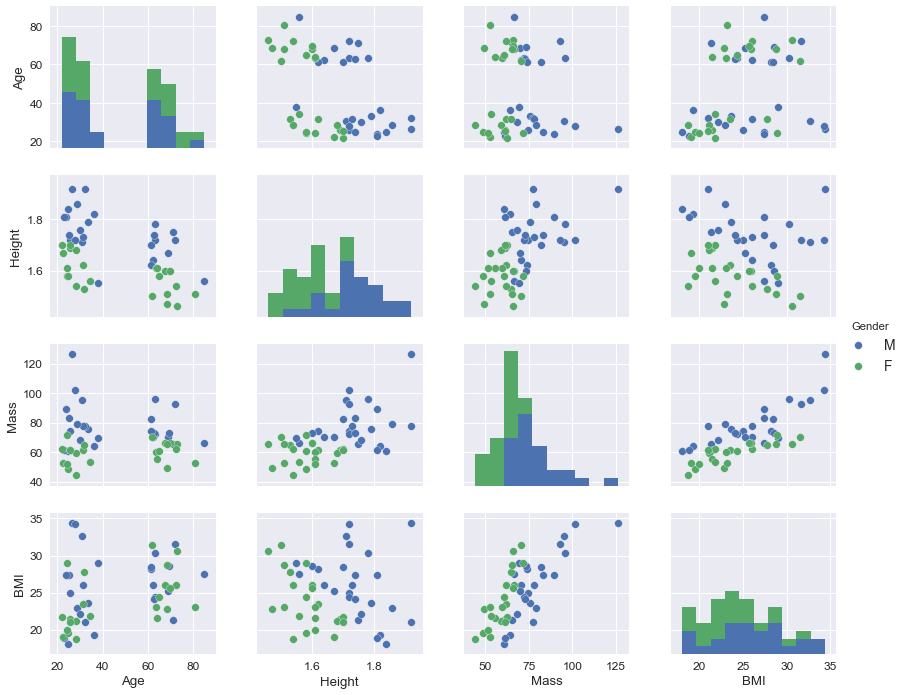

In [7]:
sns.pairplot(info[['Age', 'Gender', 'Height', 'Mass', 'BMI']], hue='Gender',
             size=2.5, aspect=1.2, plot_kws={'s':60})
plt.show()

## COP and COG displacements

Let's load the force plate and kinematics data of one subject:

In [8]:
fname_grf = os.path.join(path2, PDSinfo.Trial[150] + 'grf' + '.txt') 
fname_mkr = os.path.join(path2, PDSinfo.Trial[150] + 'mkr' + '.txt')
grf = pd.read_csv(fname_grf, delimiter='\t', header=0, engine='c')
mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
print(fname_grf, grf.shape)
print(fname_mkr, mkr.shape)

d:\X\PDS\PDS13CR1grf.txt (6000, 21)
d:\X\PDS\PDS13CR1mkr.txt (6000, 130)


Here are plots of the center of pressure (COP) data (from each force plate and the resultant COP):

In [9]:
def cop_plot(grf):
    plt.figure(figsize=(12, 6))

    gs0 = gridspec.GridSpec(1, 1)
    gs0.update(bottom=0.76, top=0.95)
    ax0 = plt.subplot(gs0[0])
    ax0.plot(grf['LCOP_Z']*100, grf['LCOP_X']*100, 'r', label='Left')
    ax0.plot(grf['RCOP_Z']*100, grf['RCOP_X']*100, 'b', label='Right')
    ax0.plot(grf['COPNET_Z']*100, grf['COPNET_X']*100, 'k', label='NET')
    #ax0.set_ylim([np.min(grf['COPNET_X'])*100-1, np.max(grf['COPNET_X'])*100+1])
    ax0.margins(0.1)
    ax0.set_xlabel('COP ml [cm]')
    ax0.set_ylabel('COP ap [cm]')
    ax0.locator_params(axis='y', nbins=4)
    ax0.yaxis.set_label_coords(-.04, 0.5)
    ax0.legend(fontsize=14, bbox_to_anchor=(0.65, 1), loc=2, borderaxespad=0., framealpha=.5)
    #ax0.legend(fontsize=14, loc='best', framealpha=.5)
    ax0.text(0.005, 0.8, 'A', transform=ax0.transAxes, fontsize=16)

    gs1 = gridspec.GridSpec(3, 2)
    gs1.update(bottom=0.05, top=0.68, hspace=0.05, wspace=0.12)
    ax1 = plt.subplot(gs1[0,0])
    ax1.plot(grf['Time'], grf['LCOP_X']*100, 'r', linewidth=1.0, label='ap')
    ax1.margins(y=0.1)
    ax1.set_xlim([0, 60])
    ax1.set_xlabel('')
    ax1.set_xticklabels('')
    ax1.set_ylabel('LCOP [cm]')
    ax1.locator_params(axis='y', nbins=3)
    ax1.yaxis.set_label_coords(-.08, 0.5)
    ax1.legend(fontsize=14, loc='lower left', framealpha=.5)
    ax1.text(0.01, 0.8, 'B', transform=ax1.transAxes, fontsize=16)
    
    ax2 = plt.subplot(gs1[0,1])
    ax2.plot(grf['Time'], grf['LCOP_Z']*100, 'r', linewidth=1.0, label='ml')
    ax2.margins(y=0.1)
    ax2.set_xlim([0, 60])
    ax2.set_xlabel('')
    ax2.set_xticklabels('')
    ax2.locator_params(axis='y', nbins=3)
    ax2.legend(fontsize=14, loc='lower left', framealpha=.5)
    ax2.text(0.01, 0.8, 'C', transform=ax2.transAxes, fontsize=16)
    
    ax3 = plt.subplot(gs1[1,0])
    ax3.plot(grf['Time'], grf['RCOP_X']*100, 'b', linewidth=1.0, label='ap')
    ax3.margins(y=0.1)
    ax3.set_xlim([0, 60])
    ax3.set_xlabel('')
    ax3.set_xticklabels('')
    ax3.set_ylabel('RCOP [cm]')
    ax3.locator_params(axis='y', nbins=3)
    ax3.yaxis.set_label_coords(-.08, 0.5)
    ax3.legend(fontsize=14, loc='lower left', framealpha=.5)
    ax3.text(0.01, 0.8, 'D', transform=ax3.transAxes, fontsize=16)
    
    ax4 = plt.subplot(gs1[1,1])
    ax4.plot(grf['Time'], grf['RCOP_Z']*100, 'b', linewidth=1.0, label='ml')
    ax4.margins(y=0.1)
    ax4.set_xlim([0, 60])
    ax4.set_xlabel('')
    ax4.set_xticklabels('')
    ax4.locator_params(axis='y', nbins=3)
    ax4.legend(fontsize=14, loc='lower left', framealpha=.5)
    ax4.text(0.01, 0.8, 'E', transform=ax4.transAxes, fontsize=16)
    
    ax5 = plt.subplot(gs1[2,0])
    ax5.plot(grf['Time'], grf['COPNET_X']*100, 'k', linewidth=1.0, label='ap')
    ax5.margins(y=0.1)
    ax5.set_xlim([0, 60])
    ax5.set_xlabel('Time [s]')
    ax5.set_ylabel('COPNET [cm]')
    ax5.locator_params(axis='y', nbins=3)
    ax5.yaxis.set_label_coords(-.08, 0.5)
    ax5.legend(fontsize=14, loc='lower left', framealpha=.5)
    ax5.text(0.01, 0.8, 'F', transform=ax5.transAxes, fontsize=16)
    
    ax6 = plt.subplot(gs1[2,1])
    ax6.plot(grf['Time'], grf['COPNET_Z']*100, 'k', linewidth=1.0, label='ml')
    ax6.margins(y=0.1)
    ax6.set_xlim([0, 60])
    ax6.set_xlabel('Time [s]')
    ax6.locator_params(axis='y', nbins=3)
    ax6.legend(fontsize=14, loc='lower left', framealpha=.5)
    ax6.text(0.01, 0.8, 'G', transform=ax6.transAxes, fontsize=16)
    
    #plt.suptitle('Center of pressure (COP) displacement during quiet standing', fontsize=14, y=1)
    plt.show()

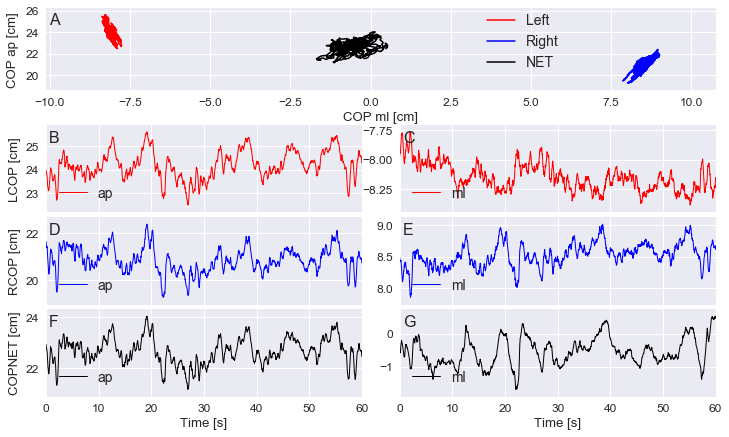

In [10]:
cop_plot(grf)

Let's plot the horizontal displacement of the center of gravity (COG) measured by the motion capture system for the COP data shown above:

In [11]:
def copcog_plot(grf, mkr):
    fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
    ax[0].plot(grf['Time'], (grf['RCOP_X']-grf['RCOP_X'].mean())*100, 'b', label='COP')
    ax[0].plot(mkr['Time'], (mkr['COG_X']-mkr['COG_X'].mean())*100, 'r', label='COG')
    ax[0].set_xlim([0, 60])
    ax[0].yaxis.set_label_coords(-.05, 0.5)
    ax[0].locator_params(axis='y', nbins=6)
    ax[0].legend(fontsize=12, loc='upper center', framealpha=.5)
    ax[0].set_ylabel('ap direction [cm]')
    ax[0].text(0.005, 0.85, 'A', transform=ax[0].transAxes, fontsize=16)
    
    ax[1].plot(grf['Time'], (grf['RCOP_Z']-grf['RCOP_Z'].mean())*100, 'b', label='COP')
    ax[1].plot(mkr['Time'], (mkr['COG_Z']-mkr['COG_Z'].mean())*100, 'r', label='COG')
    ax[1].set_xlim([0, 60])
    ax[1].yaxis.set_label_coords(-.05, 0.5)
    ax[1].locator_params(axis='y', nbins=6)
    ax[1].legend(fontsize=12, loc='upper center', framealpha=.5)
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('ml direction [cm]')
    ax[1].text(0.005, 0.85, 'B', transform=ax[1].transAxes, fontsize=16)
    
    #plt.suptitle('COP and COG displacements during quiet standing', fontsize=14, y=1)

    plt.show()

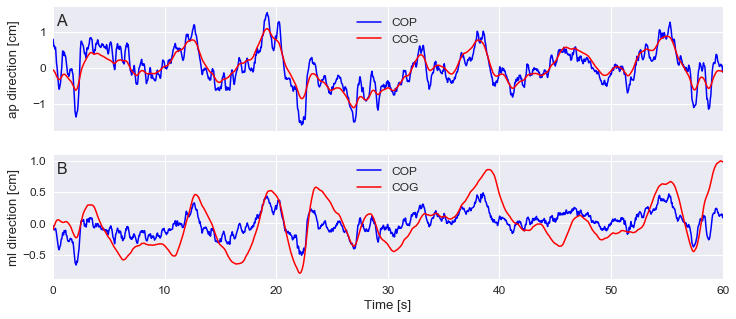

In [12]:
copcog_plot(grf, mkr)

## COP measurements

Let's load all files from the stabilography evaluation and calculate some variables to quantify the stabilography data. The notexbook http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/Stabilography.ipynb describes some of the most typical measurements employed to quantify postural sway using the COP data.  
Let's calculate here the variables COP area COP mean velocity (resultant), and COP frequency (resultant).

In [13]:
# import the python functions to calculate the COP variables
from psd import psd
from hyperellipsoid import hyperellipsoid

def COPmfreq(COP, freq):
    N = COP.shape[0]
    fp_ap, mf_ap, fmax_ap, Ptot_ap, F, P_ap = psd(COP[:, 0], fs=freq, window='hanning', nperseg=N/2,
                                                  noverlap=N/4, nfft=N/2, detrend='constant', show=False)
    fp_ml, mf_ml, fmax_ml, Ptot_ml, F, P_ml = psd(COP[:, 1], fs=freq, window='hanning', nperseg=N/2,
                                                  noverlap=N/4, nfft=N/2, detrend='constant', show=False)
    mf_res = (mf_ap*np.sum(P_ap) + mf_ml*np.sum(P_ml))/(np.sum(P_ap)+np.sum(P_ml))
    #print(mf_ap, mf_ml, mf_res)
    return mf_res

In [14]:
from scipy.signal import detrend

fp = FloatProgress(min=0, max=len(PDSinfo.Trial)-1)
display(fp)
freq = 100
for i, fname in enumerate(PDSinfo.Trial):
    filename = os.path.join(path2, fname + 'grf' + '.txt')
    fp.description = '(%s/%s)' %(i+1, len(PDSinfo.Trial))
    fp.value = i
    grf = pd.read_csv(filename, delimiter='\t', header=0, engine='c')  
    COP = grf[['COPNET_X', 'COPNET_Z']].values*100
    area, axes, angles, center, R = hyperellipsoid(COP, show=False)
    velo = np.sum(np.abs(np.sqrt(np.sum(np.diff(COP, axis=0)**2, axis=1))), axis=0)/(COP.shape[0]/freq)   
    mfreq = COPmfreq(COP, freq)
    PDSinfo.loc[i, 'COParea'] = area
    PDSinfo.loc[i, 'COPvelo'] = velo
    PDSinfo.loc[i, 'COPmfreq'] = mfreq
    
PDSinfo.to_csv(os.path.join(path2, 'PDSinfoCOP.txt'), sep='\t', encoding='utf-8', index=False)
#PDSinfo.to_excel(os.path.join(path2, 'PDSinfoCOP.xlsx'), index=False)
print('Data from %d files were processed.' %len(PDSinfo.Trial))

Data from 588 files were processed.


In [15]:
path2 = os.path.abspath(r'./../../../../X/PDS')
fname = os.path.join(path2, 'PDSinfoCOP.txt')
PDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')

In [16]:
display(PDSinfo[['Trial', 'Subject', 'Vision', 'Surface', 'COParea', 'COPvelo', 'COPmfreq']].head(15))
#qgrid.show_grid(PDSinfo[['Trial', 'Subject', 'AgeGroup', 'Vision', 'Surface', 'COParea', 'COPvelo', 'COPmfreq']])

,Trial,Subject,Vision,Surface,COParea,COPvelo,COPmfreq
0,PDS01OR1,1,Open,Rigid,3.09,0.86,0.14
1,PDS01OR2,1,Open,Rigid,2.08,0.81,0.17
2,PDS01OR3,1,Open,Rigid,5.08,0.90,0.12
3,PDS01OF1,1,Open,Foam,9.83,1.92,0.26
4,PDS01OF2,1,Open,Foam,8.41,1.62,0.23
5,PDS01OF3,1,Open,Foam,8.63,1.70,0.22
6,PDS01CR1,1,Closed,Rigid,2.84,1.14,0.26
7,PDS01CR2,1,Closed,Rigid,1.71,0.92,0.29
8,PDS01CR3,1,Closed,Rigid,2.49,0.93,0.18
9,PDS01CF1,1,Closed,Foam,9.17,2.60,0.33


In [17]:
PDSinfo = PDSinfo.groupby(['Subject', 'Vision', 'Surface', 'AgeGroup'], as_index=False).median()
display(PDSinfo[['Subject', 'Vision', 'Surface', 'COParea', 'COPvelo', 'COPmfreq']].head(12))
#qgrid.show_grid(BDSinfo[['Subject', 'Vision', 'Surface', 'COParea', 'COPvelo', 'COPmfreq']])
print('%s subjects.' %len(pd.unique(PDSinfo.Subject)))

,Subject,Vision,Surface,COParea,COPvelo,COPmfreq
0,1,Closed,Foam,11.54,2.60,0.33
1,1,Closed,Rigid,2.49,0.93,0.26
2,1,Open,Foam,8.63,1.70,0.23
3,1,Open,Rigid,3.09,0.86,0.14
4,2,Closed,Foam,21.35,3.96,0.33
5,2,Closed,Rigid,5.07,1.65,0.22
6,2,Open,Foam,12.75,2.75,0.33
7,2,Open,Rigid,3.56,1.08,0.17
8,3,Closed,Foam,6.94,2.25,0.35
9,3,Closed,Rigid,2.19,1.03,0.25


49 subjects.


Let's plot the variables COP area, COP velocity and COP mean frequency for each subject by age group at the different conditions:

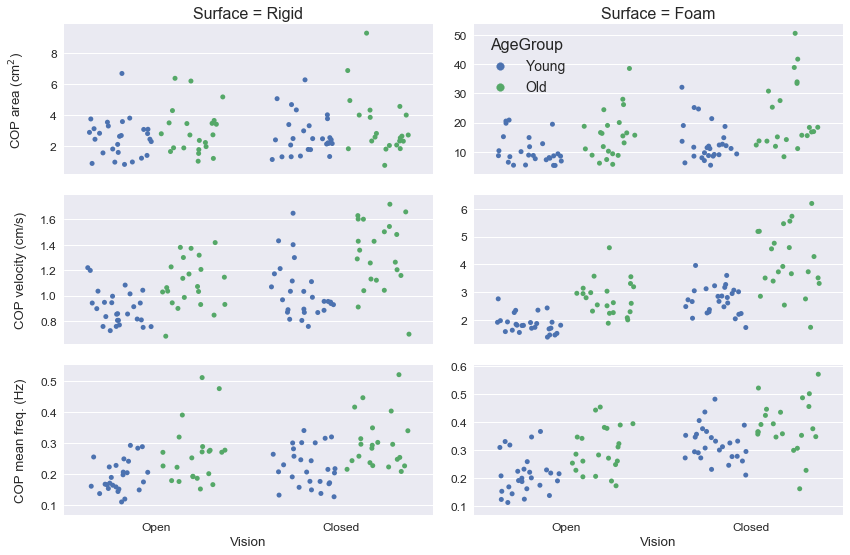

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(12, 8))

sns.stripplot(x='Vision', y='COParea', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Rigid'],
               jitter=.35, split=True, size=4, ax=ax[0,0], s=5)
ax[0,0].set_xlabel('')
ax[0,0].set_xticklabels('')
ax[0,0].set_ylabel('COP area (cm$^2$)')
ax[0,0].yaxis.set_label_coords(-.1, .5)
ax[0,0].legend('')
ax[0,0].set_title('Surface = Rigid', fontsize=16)
sns.stripplot(x='Vision', y='COParea', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[0,1], s=5)
ax[0,1].set_xlabel('')
ax[0,1].set_xticklabels('')
ax[0,1].set_ylabel('')
ax[0,1].legend(title='AgeGroup', loc='upper left')
ax[0,1].set_title('Surface = Foam', fontsize=16)

sns.stripplot(x='Vision', y='COPvelo', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Rigid'],
               jitter=.35, split=True, size=4, ax=ax[1,0], s=5)
ax[1,0].set_xlabel('')
ax[1,0].set_xticklabels('')
ax[1,0].set_ylabel('COP velocity (cm/s)')
ax[1,0].yaxis.set_label_coords(-.1, .5)
ax[1,0].legend('')
sns.stripplot(x='Vision', y='COPvelo', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[1,1], s=5)
ax[1,1].set_xlabel('')
ax[1,1].set_xticklabels('')
ax[1,1].set_ylabel('')
ax[1,1].legend('')

sns.stripplot(x='Vision', y='COPmfreq', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Rigid'],
               jitter=.35, split=True, size=4, ax=ax[2,0], s=5)
ax[2,0].set_ylabel('COP mean freq. (Hz)')
ax[2,0].yaxis.set_label_coords(-.1, .5)
ax[2,0].legend('')

sns.stripplot(x='Vision', y='COPmfreq', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[2,1], s=5)
ax[2,1].set_ylabel('')
ax[2,1].legend('')

plt.tight_layout()
plt.show()

The mean and standard deviation values for the variables COP area, COP velocity and COP mean frequency are:

In [19]:
pd.set_option('precision', 3)
PDSinfo.groupby(['AgeGroup', 'Vision', 'Surface'])['COParea', 'COPvelo', 'COPmfreq'].agg([np.mean, np.std])

COParea         COPvelo        COPmfreq       
                           mean     std    mean    std     mean    std
AgeGroup Vision Surface                                               
Old      Closed Foam     21.998  11.565   4.098  1.158    0.386  0.093
                Rigid     3.308   1.900   1.320  0.267    0.301  0.083
         Open   Foam     15.772   8.102   2.788  0.634    0.301  0.081
                Rigid     2.984   1.485   1.096  0.191    0.263  0.094
Young    Closed Foam     13.037   6.479   2.727  0.509    0.322  0.062
                Rigid     2.735   1.271   1.031  0.212    0.224  0.063
         Open   Foam     10.411   4.864   1.849  0.330    0.213  0.070
                Rigid     2.547   1.244   0.901  0.134    0.193  0.051

And the corresponding plots for the mean and standard deviation values for the variables COP area, COP velocity and COP mean frequency are:

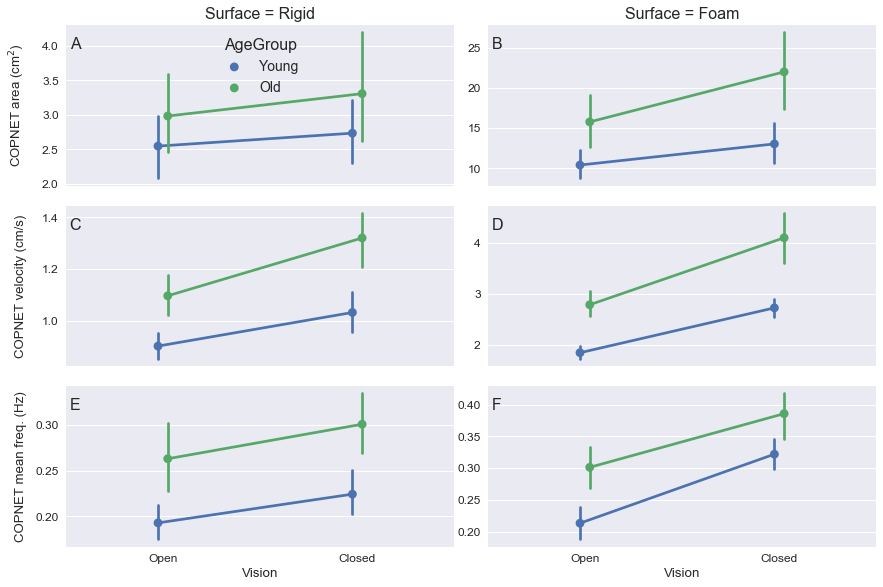

In [20]:
fig, ax = plt.subplots(3, 2, figsize=(12, 8))

sns.pointplot(x='Vision', y='COParea', hue='AgeGroup', order=['Open', 'Closed'],
               data=PDSinfo[PDSinfo.Surface=='Rigid'], estimator=np.mean, ci=95, kind='point',
               split=True, dodge=True, size=4, ax=ax[0,0], s=5)
ax[0,0].set_xlabel('')
ax[0,0].set_xticklabels('')
ax[0,0].set_ylabel('COPNET area (cm$^2$)')
ax[0,0].yaxis.set_label_coords(-.1, .5)
ax[0,0].legend(title='AgeGroup', loc='upper center')
ax[0,0].set_title('Surface = Rigid', fontsize=16)
ax[0,0].text(0.01, 0.85, 'A', transform=ax[0,0].transAxes, fontsize=16)

sns.pointplot(x='Vision', y='COParea', hue='AgeGroup', order=['Open', 'Closed'],
               data=PDSinfo[PDSinfo.Surface=='Foam'],
               split=True, dodge=True, size=4, ax=ax[0,1], s=5)
ax[0,1].set_xlabel('')
ax[0,1].set_xticklabels('')
ax[0,1].set_ylabel('')
ax[0,1].legend('')
ax[0,1].set_title('Surface = Foam', fontsize=16)
ax[0,1].text(0.01, 0.85, 'B', transform=ax[0,1].transAxes, fontsize=16)

sns.pointplot(x='Vision', y='COPvelo', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Rigid'],
               split=True, dodge=True, size=4, ax=ax[1,0], s=5)
ax[1,0].set_xlabel('')
ax[1,0].set_xticklabels('')
ax[1,0].set_ylabel('COPNET velocity (cm/s)')
ax[1,0].yaxis.set_label_coords(-.1, .5)
ax[1,0].legend('')
ax[1,0].text(0.01, 0.85, 'C', transform=ax[1,0].transAxes, fontsize=16)

sns.pointplot(x='Vision', y='COPvelo', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Foam'],
               split=True, dodge=True, size=4, ax=ax[1,1], s=5)
ax[1,1].set_xlabel('')
ax[1,1].set_xticklabels('')
ax[1,1].set_ylabel('')
ax[1,1].legend('')
ax[1,1].text(0.01, 0.85, 'D', transform=ax[1,1].transAxes, fontsize=16)

sns.pointplot(x='Vision', y='COPmfreq', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Rigid'],
               split=True, dodge=True, size=4, ax=ax[2,0], s=5)
ax[2,0].set_ylabel('COPNET mean freq. (Hz)')
ax[2,0].yaxis.set_label_coords(-.1, .5)
ax[2,0].legend('')
ax[2,0].text(0.01, 0.85, 'E', transform=ax[2,0].transAxes, fontsize=16)

sns.pointplot(x='Vision', y='COPmfreq', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Foam'],
               split=True, dodge=True, size=4, ax=ax[2,1], s=5)
ax[2,1].set_ylabel('')
ax[2,1].legend('')
ax[2,1].text(0.01, 0.85, 'F', transform=ax[2,1].transAxes, fontsize=16)

plt.tight_layout(pad=0.1, w_pad=0.6, h_pad=0.05)
plt.show()

## Kinematics

Let's load and visualize the kinematic data for one trial:

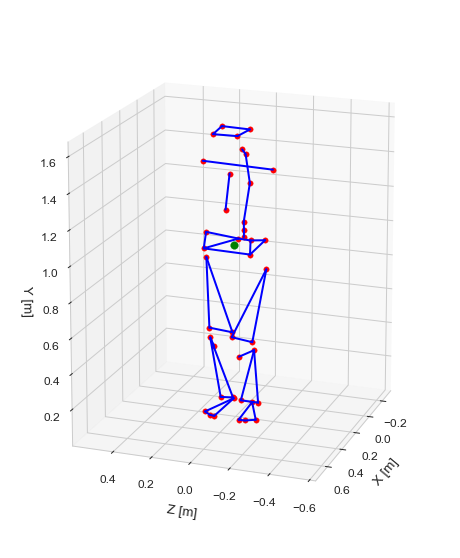

In [21]:
sns.set_style("whitegrid")

path2 = os.path.abspath(r'./../../../../X/PDS')
fname = os.path.join(path2, 'PDSinfo.txt')
PDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
fname_mkr = os.path.join(path2, PDSinfo.Trial[150] + 'mkr' + '.txt') 
mkr = pd.read_csv(fname_mkr, delimiter='\t', header=0, engine='c')
mkrm = mkr.iloc[:, 1::].mean().values
seg = [[0,1],[1,3],[3,2],[2,0],                                          # head
       [4,5],                                                            # shoulder
       [6,7],[7,8],[8,9],[9,10],[10,11],                                 # spine
       [12,13],                                                          # front trunk
       [14,15],[14,16],[15,17],[16,17],[14,19],[16,19],[15,18],[17,18],  # pelvis
       [20,22],[22,23],[23,20],                                          # right tigh   
       [26,28],[26,30],[30,31],[31,26],                                  # right leg
       [21,24],[24,25],[25,21],                                          # left tigh   
       [27,29],[27,32],[32,33],[33,27],                                  # left leg
       [34,36],[36,37],[37,38],[38,34],                                  # right foot
       [35,39],[39,40],[40,41],[41,35]]                                  # left foot

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d',  facecolor='white')
ax.view_init(15, 20)

for s in seg:
    ax.plot(mkrm[[s[0]*3,s[1]*3]], mkrm[[s[0]*3+2,s[1]*3+2]], mkrm[[s[0]*3+1,s[1]*3+1]],
           linewidth=2, c='b')

ax.scatter(mkrm[0:-3:3], mkrm[2:-1:3], mkrm[1:-2:3], c='r', s=30, depthshade=False)
ax.scatter(mkrm[-3], mkrm[-1], mkrm[-2], c='g', s=60, depthshade=False)

ax.set_xlim3d([np.nanmin(mkrm[0::3])-.4, np.nanmax(mkrm[0::3])+.4])
ax.set_ylim3d([np.nanmin(mkrm[2::3])-.4, np.nanmax(mkrm[2::3])+.4])
ax.set_zlim3d([np.nanmin(mkrm[1::3]), np.nanmax(mkrm[1::3])])
ax.set_xlabel('\n' + 'X [m]', linespacing=2)
ax.set_ylabel('\n' + 'Z [m]', linespacing=2)
ax.set_zlabel('\n' + 'Y [m]', linespacing=2)
ax.invert_yaxis()

plt.show()

## Joint angular displacement at sagital plane

In [22]:
sns.set_style("darkgrid")

fname = os.path.join(path2, 'PDSinfo.txt')
PDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')

angz_l = ['LHe_Th_Angle_Z', 'RHe_Th_Angle_Z',
          'LTh_Pel_Angle_Z', 'RTh_Pel_Angle_Z',
          'LHip_Angle_Z', 'RHip_Angle_Z',
          'LKnee_Angle_Z', 'RKnee_Angle_Z',
          'LAnkle_Angle_Z', 'RAnkle_Angle_Z']
label = ['L Trunk/Head', 'R Trunk/Head', 'L Pelvis/Trunk', 'R Pelvis/Trunk', 
         'L Hip', 'R Hip', 'L Knee', 'R Knee', 'L Ankle', 'R Ankle']

def angz_plot(angles, angz_l):
    fig, ax = plt.subplots(5, 2, figsize=(12, 6), sharex=True)
    axs = ax.flatten()
    color = ['r', 'b']
    letters = 'ABCDEFGHIJ'
    for i, ax in enumerate(axs):
        ax.plot(angles['Time'], angles[[angz_l[i]]], color[i%2], label=label[int(i)])
        ax.locator_params(axis='y', nbins=4)
        ax.set_xlim([0, 60])
        ax.text(0.01, 0.95, letters[i], transform=ax.transAxes, fontsize=16)
        ax.legend(fontsize=12, loc='best', framealpha=.5)
        if i > 7:
            ax.set_xlabel('Time [s]')
        if not i%2:
            ax.set_ylabel('Angle [$^o$]')
            ax.yaxis.set_label_coords(-.1, .5)
    
    #plt.suptitle('Joint angular displacement at sagital plane', fontsize=16, y=1)
    plt.tight_layout()
    plt.show()

d:\X\PDS\PDS13CR1ang.txt (6000, 74)


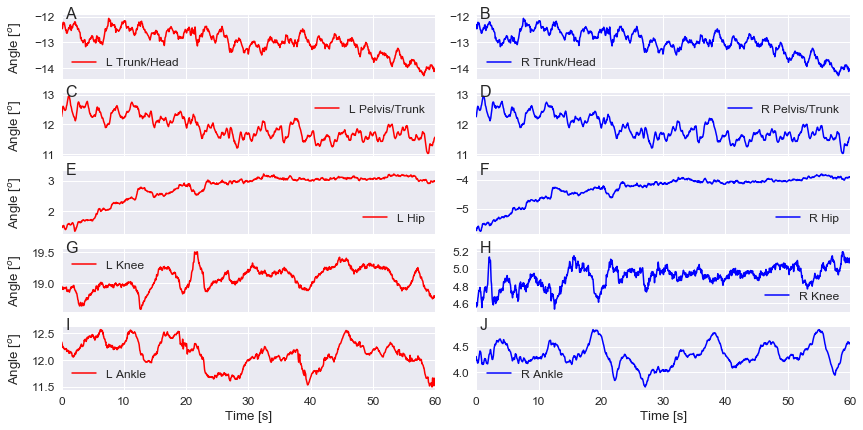

In [23]:
fname_ang = os.path.join(path2, PDSinfo.Trial[150] + 'ang' + '.txt') 
angles = pd.read_csv(fname_ang, delimiter='\t', header=0, engine='c')
print(fname_ang, angles.shape)
angz_plot(angles, angz_l)

In [24]:
fp = FloatProgress(min=0, max=len(PDSinfo.Trial)-1)
display(fp)
for i, fname in enumerate(PDSinfo.Trial):
    filename = os.path.join(path2, fname + 'ang' + '.txt')
    fp.description = '(%s/%s)' %(i+1, len(PDSinfo.Trial))
    fp.value = i
    angs = pd.read_csv(filename, delimiter='\t', header=0, engine='c')  
    ang2 = angs[angz_l].std().values.reshape(5, 2).mean(axis=1)
    PDSinfo.loc[i, 'He_Th_Angle_Z'] = ang2[0]
    PDSinfo.loc[i, 'Th_Pel_Angle_Z'] = ang2[1]
    PDSinfo.loc[i, 'Hip_Angle_Z'] = ang2[2]
    PDSinfo.loc[i, 'Knee_Angle_Z'] = ang2[3]
    PDSinfo.loc[i, 'Ankle_Angle_Z'] = ang2[4]
    
PDSinfo.to_csv(os.path.join(path2, 'PDSinfoANG.txt'), sep='\t', encoding='utf-8', index=False)
#print('Data from %d files were processed.' %len(PDSinfo.Trial))

In [25]:
path2 = os.path.abspath(r'./../../../../X/PDS')
fname = os.path.join(path2, 'PDSinfoANG.txt')
PDSinfo = pd.read_csv(fname, sep='\t', header=0, index_col=None, engine='c', encoding='utf-8')
PDSinfo = PDSinfo.groupby(['Subject', 'Vision', 'Surface', 'AgeGroup'], as_index=False).median()

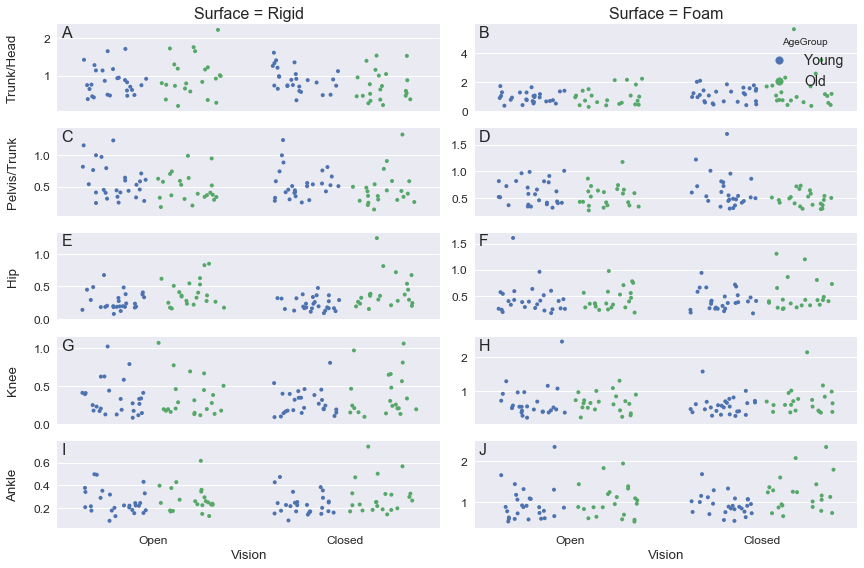

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(12, 8))

sns.stripplot(x='Vision', y='He_Th_Angle_Z', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Rigid'],
               jitter=.35, split=True, size=4, ax=ax[0,0], s=4)
ax[0,0].set_xlabel('')
ax[0,0].set_xticklabels('')
ax[0,0].set_ylabel('Trunk/Head')
ax[0,0].yaxis.set_label_coords(-.1, .5)
ax[0,0].legend('')
ax[0,0].set_title('Surface = Rigid', fontsize=16)
ax[0,0].locator_params(axis='y', nbins=4)
ax[0,0].text(0.01, 0.85, 'A', transform=ax[0,0].transAxes, fontsize=16)

sns.stripplot(x='Vision', y='He_Th_Angle_Z', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[0,1], s=4)
ax[0,1].set_xlabel('')
ax[0,1].set_xticklabels('')
ax[0,1].set_ylabel('')
ax[0,1].legend(title='AgeGroup', loc='best')
ax[0,1].set_title('Surface = Foam', fontsize=16)
ax[0,1].locator_params(axis='y', nbins=4)
ax[0,1].text(0.01, 0.85, 'B', transform=ax[0,1].transAxes, fontsize=16)

sns.stripplot(x='Vision', y='Th_Pel_Angle_Z', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Rigid'],
               jitter=.35, split=True, size=4, ax=ax[1,0], s=4)
ax[1,0].set_xlabel('')
ax[1,0].set_xticklabels('')
ax[1,0].set_ylabel('Pelvis/Trunk')
ax[1,0].yaxis.set_label_coords(-.1, .5)
ax[1,0].legend('')
ax[1,0].locator_params(axis='y', nbins=4)
ax[1,0].text(0.01, 0.85, 'C', transform=ax[1,0].transAxes, fontsize=16)

sns.stripplot(x='Vision', y='Th_Pel_Angle_Z', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[1,1], s=4)
ax[1,1].set_xlabel('')
ax[1,1].set_xticklabels('')
ax[1,1].set_ylabel('')
ax[1,1].legend('')
ax[1,1].locator_params(axis='y', nbins=4)
ax[1,1].text(0.01, 0.85, 'D', transform=ax[1,1].transAxes, fontsize=16)

sns.stripplot(x='Vision', y='Hip_Angle_Z', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Rigid'],
               jitter=.35, split=True, size=4, ax=ax[2,0], s=4)
ax[2,0].set_xlabel('')
ax[2,0].set_xticklabels('')
ax[2,0].set_ylabel('Hip')
ax[2,0].yaxis.set_label_coords(-.1, .5)
ax[2,0].legend('')
ax[2,0].locator_params(axis='y', nbins=4)
ax[2,0].text(0.01, 0.85, 'E', transform=ax[2,0].transAxes, fontsize=16)

sns.stripplot(x='Vision', y='Hip_Angle_Z', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[2,1], s=4)
ax[2,1].set_xlabel('')
ax[2,1].set_xticklabels('')
ax[2,1].set_ylabel('')
ax[2,1].legend('')
ax[2,1].locator_params(axis='y', nbins=4)
ax[2,1].text(0.01, 0.85, 'F', transform=ax[2,1].transAxes, fontsize=16)

sns.stripplot(x='Vision', y='Knee_Angle_Z', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Rigid'],
               jitter=.35, split=True, size=4, ax=ax[3,0], s=4)
ax[3,0].set_xlabel('')
ax[3,0].set_xticklabels('')
ax[3,0].set_ylabel('Knee')
ax[3,0].yaxis.set_label_coords(-.1, .5)
ax[3,0].legend('')
ax[3,0].locator_params(axis='y', nbins=4)
ax[3,0].text(0.01, 0.85, 'G', transform=ax[3,0].transAxes, fontsize=16)

sns.stripplot(x='Vision', y='Knee_Angle_Z', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[3,1], s=4)
ax[3,1].set_xlabel('')
ax[3,1].set_xticklabels('')
ax[3,1].set_ylabel('')
ax[3,1].legend('')
ax[3,1].locator_params(axis='y', nbins=4)
ax[3,1].text(0.01, 0.85, 'H', transform=ax[3,1].transAxes, fontsize=16)

sns.stripplot(x='Vision', y='Ankle_Angle_Z', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Rigid'],
               jitter=.35, split=True, size=4, ax=ax[4,0], s=4)
ax[4,0].set_ylabel('Ankle')
ax[4,0].yaxis.set_label_coords(-.1, .5)
ax[4,0].legend('')
ax[4,0].locator_params(axis='y', nbins=4)
ax[4,0].text(0.01, 0.85, 'I', transform=ax[4,0].transAxes, fontsize=16)

sns.stripplot(x='Vision', y='Ankle_Angle_Z', hue='AgeGroup', order=['Open', 'Closed'], data=PDSinfo[PDSinfo.Surface=='Foam'],
               jitter=.35, split=True, size=4, ax=ax[4,1], s=4)
ax[4,1].set_ylabel('')
ax[4,1].legend('')
ax[4,1].locator_params(axis='y', nbins=4)
ax[4,1].text(0.01, 0.85, 'J', transform=ax[4,1].transAxes, fontsize=16)

plt.tight_layout()
plt.show()

In [27]:
cats = PDSinfo[['AgeGroup', 'Surface', 'Vision']]
n = cats.shape[0]
cats = pd.concat([cats, cats, cats, cats, cats], ignore_index=True)
joints = np.asarray([['Trunk/Head']*n, ['Pelvis/Trunk']*n, ['Hip']*n,
                     ['Knee']*n, ['Ankle']*n]).reshape(cats.shape[0])
angs = PDSinfo[['He_Th_Angle_Z', 'Th_Pel_Angle_Z','Hip_Angle_Z', 'Knee_Angle_Z',
                'Ankle_Angle_Z']].values.reshape(joints.shape[0], order='F')
data = cats.assign(Joint=joints)
data = data.assign(Angle=angs)

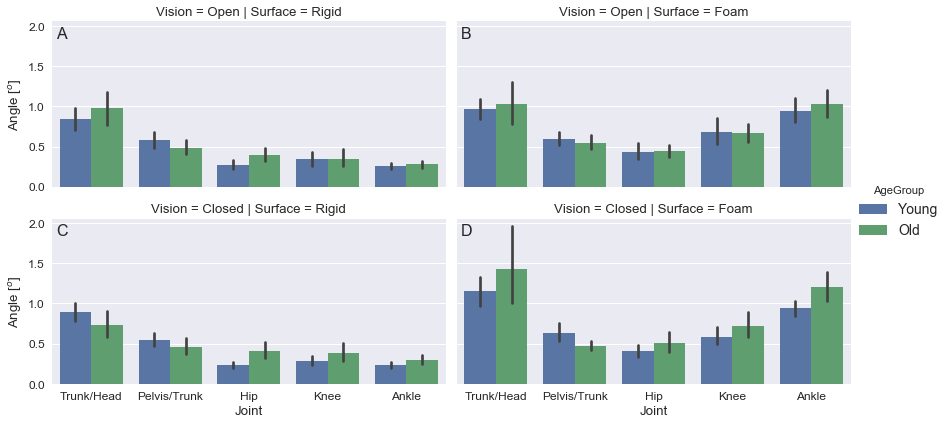

In [28]:
g = sns.factorplot(x='Joint', y='Angle', col='Surface', row='Vision', hue='AgeGroup', data=data,
                   size=3, aspect=2, kind='bar', row_order=['Open', 'Closed'], col_order=['Rigid', 'Foam'])
g.despine(left=True)
g.set_ylabels('Angle [$^o$]')
g.axes[0,0].text(0.01, 0.9, 'A', transform=g.axes[0,0].transAxes, fontsize=16)
g.axes[0,1].text(0.01, 0.9, 'B', transform=g.axes[0,1].transAxes, fontsize=16)
g.axes[1,0].text(0.01, 0.9, 'C', transform=g.axes[1,0].transAxes, fontsize=16)
g.axes[1,1].text(0.01, 0.9, 'D', transform=g.axes[1,1].transAxes, fontsize=16)
#plt.suptitle('Joint angular displacement at sagital plane', fontsize=16, y=1.05)
plt.show()